### Stacking the best regression predictor and the neural network

In [11]:
import importlib
import helper_functions
import pandas as pd
importlib.reload(helper_functions)
from helper_functions import *
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline, FeatureUnion, _transform_one
from sklearn.externals.joblib import Parallel, delayed

In [12]:
# Defining pipeline as in other examples
trans_pipeline = Pipeline([
    ('impute_numerical', DFTransform(lambda X: fill_numerical_nans(X))),
    ('impute_categorical', DFTransform(lambda X: impute_categorical(X))),
    ('impute_special_cases', DFTransform(lambda X: impute_special_cases(X))),
    ('drop_features', DFTransform(lambda X: drop_features(X))),
    ('ordinal_features', DFTransform(lambda X: encode_ordinals(X))),
    ('check_nans', DFTransform(lambda X: check_nans(X))),
    ('encode_dummies', DFTransform(lambda X: create_dummies(X)))
    ])

In [14]:
# Load the data
train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_test = pd.read_csv('data/test.csv').drop(['Id'], axis=1)
X_train, y_train = prepare_inputs(X_train, y_train)

# Transforming the input
X_combined = pd.concat((X_train, X_test)).reset_index(drop=True) 
X_tranformed = trans_pipeline.fit_transform(X_combined)

# Split the transformed input back
X_train_trans = X_tranformed[:X_train.shape[0]] 
X_test_trans = X_tranformed[X_train.shape[0]:]

Creating dummies...
Starting with input of shape: (2915, 78)
Returning output of shape: (2915, 219)


In [15]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_train_trans, y_train, test_size=.2, random_state=42)

# Split the training set into two subsets for prediction and blending
X_train_subset1, X_train_subset2, y_train_subset1, y_train_subset2 = \
                                    train_test_split(X_train, y_train, test_size=.2, random_state=42)

In [26]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Ridge

# Define first estimator
adaboost_estimator = AdaBoostRegressor(base_estimator=Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='cholesky', tol=0.001),
         learning_rate=.001, loss='linear', n_estimators=100,
         random_state=42)

In [27]:
# Train the first estimator on the first subset
adaboost_estimator.fit(X_train_subset1, y_train_subset1)

AdaBoostRegressor(base_estimator=Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='cholesky', tol=0.001),
         learning_rate=0.001, loss='linear', n_estimators=100,
         random_state=42)

In [28]:
# Predict with the first estimator on the second subset
prediction_adaboost = adaboost_estimator.predict(X_train_subset2)

In [31]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from keras.callbacks import ModelCheckpoint  
import livelossplot as lp
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation


# Define the build function for the second estimator
def build_nn():
    model = Sequential()
    model.add(Dense(219, kernel_initializer='normal', activation='relu', input_shape=(219,)))
    model.add(Dropout(.3))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(50, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(.1))
    model.add(Dense(1, kernel_initializer='normal', activation='relu'))

    # Compiling the mode
    model.compile(loss = 'mean_squared_error', optimizer='adam')
    return model

In [34]:
# Define pipeline with scaler for second regressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp_regressor', KerasRegressor(build_fn=build_nn, batch_size=5, epochs=1000, verbose=1))
])

In [35]:
# Train the second estimator on the first subset
pipeline.fit(X_train_subset1, y_train_subset1)

Epoch 1/1000
931/931 [==============================] - 1s 795us/step - loss: 22.1282
Epoch 2/1000
931/931 [==============================] - 0s 472us/step - loss: 3.9908
Epoch 3/1000
931/931 [==============================] - 0s 470us/step - loss: 3.3564
Epoch 4/1000
931/931 [==============================] - 0s 469us/step - loss: 3.3305
Epoch 5/1000
931/931 [==============================] - 0s 485us/step - loss: 3.1648
Epoch 6/1000
931/931 [==============================] - 0s 472us/step - loss: 2.9153
Epoch 7/1000
931/931 [==============================] - 0s 475us/step - loss: 2.7590
Epoch 8/1000
931/931 [==============================] - 0s 482us/step - loss: 2.3854
Epoch 9/1000
931/931 [==============================] - 0s 471us/step - loss: 2.8684
Epoch 10/1000
931/931 [==============================] - 0s 484us/step - loss: 2.6487
Epoch 11/1000
931/931 [==============================] - 0s 490us/step - loss: 2.3104
Epoch 12/1000
931/931 [==============================] - 0s 47

931/931 [==============================] - 0s 502us/step - loss: 0.3443
Epoch 97/1000
931/931 [==============================] - 0s 468us/step - loss: 0.3481
Epoch 98/1000
931/931 [==============================] - 0s 452us/step - loss: 0.3625
Epoch 99/1000
931/931 [==============================] - 0s 530us/step - loss: 0.3611
Epoch 100/1000
931/931 [==============================] - 0s 452us/step - loss: 0.3385
Epoch 101/1000
931/931 [==============================] - 0s 451us/step - loss: 0.3407
Epoch 102/1000
931/931 [==============================] - 0s 462us/step - loss: 0.3260
Epoch 103/1000
931/931 [==============================] - 0s 515us/step - loss: 0.3468
Epoch 104/1000
931/931 [==============================] - 0s 452us/step - loss: 0.3199
Epoch 105/1000
931/931 [==============================] - 0s 452us/step - loss: 0.3158
Epoch 106/1000
931/931 [==============================] - 0s 449us/step - loss: 0.3409
Epoch 107/1000
931/931 [==============================] - 0s 

931/931 [==============================] - 0s 460us/step - loss: 0.2152
Epoch 191/1000
931/931 [==============================] - 0s 430us/step - loss: 0.2067
Epoch 192/1000
931/931 [==============================] - 0s 446us/step - loss: 0.1969
Epoch 193/1000
931/931 [==============================] - 0s 432us/step - loss: 0.1955
Epoch 194/1000
931/931 [==============================] - 0s 436us/step - loss: 0.1786
Epoch 195/1000
931/931 [==============================] - 0s 429us/step - loss: 0.2091
Epoch 196/1000
931/931 [==============================] - 0s 434us/step - loss: 0.1745
Epoch 197/1000
931/931 [==============================] - 0s 436us/step - loss: 0.1962
Epoch 198/1000
931/931 [==============================] - 0s 429us/step - loss: 0.1968
Epoch 199/1000
931/931 [==============================] - 0s 440us/step - loss: 0.1754
Epoch 200/1000
931/931 [==============================] - 0s 432us/step - loss: 0.1812
Epoch 201/1000
931/931 [==============================] - 

931/931 [==============================] - 0s 457us/step - loss: 0.1202
Epoch 285/1000
931/931 [==============================] - 0s 435us/step - loss: 0.1225
Epoch 286/1000
931/931 [==============================] - 0s 423us/step - loss: 0.1028
Epoch 287/1000
931/931 [==============================] - 0s 430us/step - loss: 0.1105
Epoch 288/1000
931/931 [==============================] - 0s 435us/step - loss: 0.1088
Epoch 289/1000
931/931 [==============================] - 0s 424us/step - loss: 0.1004
Epoch 290/1000
931/931 [==============================] - 0s 444us/step - loss: 0.1242
Epoch 291/1000
931/931 [==============================] - 0s 427us/step - loss: 0.1129
Epoch 292/1000
931/931 [==============================] - 0s 443us/step - loss: 0.0977
Epoch 293/1000
931/931 [==============================] - 0s 450us/step - loss: 0.1108
Epoch 294/1000
931/931 [==============================] - 0s 432us/step - loss: 0.1075
Epoch 295/1000
931/931 [==============================] - 

931/931 [==============================] - 0s 461us/step - loss: 0.0594
Epoch 379/1000
931/931 [==============================] - 0s 440us/step - loss: 0.0621
Epoch 380/1000
931/931 [==============================] - 0s 426us/step - loss: 0.0590
Epoch 381/1000
931/931 [==============================] - 0s 436us/step - loss: 0.0673
Epoch 382/1000
931/931 [==============================] - 0s 435us/step - loss: 0.0615
Epoch 383/1000
931/931 [==============================] - 0s 434us/step - loss: 0.0581
Epoch 384/1000
931/931 [==============================] - 0s 434us/step - loss: 0.0632
Epoch 385/1000
931/931 [==============================] - 0s 433us/step - loss: 0.0537
Epoch 386/1000
931/931 [==============================] - 0s 433us/step - loss: 0.0606
Epoch 387/1000
931/931 [==============================] - 0s 430us/step - loss: 0.0504
Epoch 388/1000
931/931 [==============================] - 0s 429us/step - loss: 0.0576
Epoch 389/1000
931/931 [==============================] - 

931/931 [==============================] - 0s 451us/step - loss: 0.0287
Epoch 473/1000
931/931 [==============================] - 0s 437us/step - loss: 0.0295
Epoch 474/1000
931/931 [==============================] - 0s 455us/step - loss: 0.0339
Epoch 475/1000
931/931 [==============================] - 0s 434us/step - loss: 0.0312
Epoch 476/1000
931/931 [==============================] - 0s 433us/step - loss: 0.0285
Epoch 477/1000
931/931 [==============================] - 0s 435us/step - loss: 0.0286
Epoch 478/1000
931/931 [==============================] - 0s 436us/step - loss: 0.0288
Epoch 479/1000
931/931 [==============================] - 0s 434us/step - loss: 0.0253
Epoch 480/1000
931/931 [==============================] - 0s 433us/step - loss: 0.0277
Epoch 481/1000
931/931 [==============================] - 0s 442us/step - loss: 0.0261
Epoch 482/1000
931/931 [==============================] - 0s 445us/step - loss: 0.0250
Epoch 483/1000
931/931 [==============================] - 

931/931 [==============================] - 0s 457us/step - loss: 0.0162
Epoch 567/1000
931/931 [==============================] - 0s 435us/step - loss: 0.0148
Epoch 568/1000
931/931 [==============================] - 0s 437us/step - loss: 0.0139
Epoch 569/1000
931/931 [==============================] - 0s 426us/step - loss: 0.0150
Epoch 570/1000
931/931 [==============================] - 0s 434us/step - loss: 0.0150
Epoch 571/1000
931/931 [==============================] - 0s 472us/step - loss: 0.0151
Epoch 572/1000
931/931 [==============================] - 0s 495us/step - loss: 0.0153
Epoch 573/1000
931/931 [==============================] - 0s 454us/step - loss: 0.0156
Epoch 574/1000
931/931 [==============================] - 0s 461us/step - loss: 0.0136
Epoch 575/1000
931/931 [==============================] - 0s 507us/step - loss: 0.0167
Epoch 576/1000
931/931 [==============================] - 0s 461us/step - loss: 0.0133
Epoch 577/1000
931/931 [==============================] - 

931/931 [==============================] - 0s 472us/step - loss: 0.0171
Epoch 661/1000
931/931 [==============================] - 0s 438us/step - loss: 0.0118
Epoch 662/1000
931/931 [==============================] - 0s 428us/step - loss: 0.0123
Epoch 663/1000
931/931 [==============================] - 0s 436us/step - loss: 0.0124
Epoch 664/1000
931/931 [==============================] - 0s 433us/step - loss: 0.0135
Epoch 665/1000
931/931 [==============================] - 0s 443us/step - loss: 0.0133
Epoch 666/1000
931/931 [==============================] - 0s 433us/step - loss: 0.0139
Epoch 667/1000
931/931 [==============================] - 0s 430us/step - loss: 0.0134
Epoch 668/1000
931/931 [==============================] - 0s 434us/step - loss: 0.0119
Epoch 669/1000
931/931 [==============================] - 0s 436us/step - loss: 0.0137
Epoch 670/1000
931/931 [==============================] - 0s 431us/step - loss: 0.0125
Epoch 671/1000
931/931 [==============================] - 

931/931 [==============================] - 0s 459us/step - loss: 0.0138
Epoch 755/1000
931/931 [==============================] - 0s 435us/step - loss: 0.0130
Epoch 756/1000
931/931 [==============================] - 0s 433us/step - loss: 0.0157
Epoch 757/1000
931/931 [==============================] - 0s 425us/step - loss: 0.0116
Epoch 758/1000
931/931 [==============================] - 0s 438us/step - loss: 0.0135
Epoch 759/1000
931/931 [==============================] - 0s 435us/step - loss: 0.0129
Epoch 760/1000
931/931 [==============================] - 0s 432us/step - loss: 0.0141
Epoch 761/1000
931/931 [==============================] - 0s 451us/step - loss: 0.0132
Epoch 762/1000
931/931 [==============================] - 0s 429us/step - loss: 0.0145
Epoch 763/1000
931/931 [==============================] - 0s 437us/step - loss: 0.0121
Epoch 764/1000
931/931 [==============================] - 0s 435us/step - loss: 0.0142
Epoch 765/1000
931/931 [==============================] - 

931/931 [==============================] - 0s 460us/step - loss: 0.0109
Epoch 849/1000
931/931 [==============================] - 0s 436us/step - loss: 0.0118
Epoch 850/1000
931/931 [==============================] - 0s 427us/step - loss: 0.0136
Epoch 851/1000
931/931 [==============================] - 0s 437us/step - loss: 0.0106
Epoch 852/1000
931/931 [==============================] - 0s 438us/step - loss: 0.0103
Epoch 853/1000
931/931 [==============================] - 0s 426us/step - loss: 0.0158
Epoch 854/1000
931/931 [==============================] - 0s 455us/step - loss: 0.0122
Epoch 855/1000
931/931 [==============================] - 0s 432us/step - loss: 0.0119
Epoch 856/1000
931/931 [==============================] - 0s 440us/step - loss: 0.0119
Epoch 857/1000
931/931 [==============================] - 0s 435us/step - loss: 0.0126
Epoch 858/1000
931/931 [==============================] - 0s 443us/step - loss: 0.0111
Epoch 859/1000
931/931 [==============================] - 

931/931 [==============================] - 0s 461us/step - loss: 0.0115
Epoch 943/1000
931/931 [==============================] - 0s 438us/step - loss: 0.0132
Epoch 944/1000
931/931 [==============================] - 0s 430us/step - loss: 0.0113
Epoch 945/1000
931/931 [==============================] - 0s 451us/step - loss: 0.0111
Epoch 946/1000
931/931 [==============================] - 0s 432us/step - loss: 0.0121
Epoch 947/1000
931/931 [==============================] - 0s 449us/step - loss: 0.0116
Epoch 948/1000
931/931 [==============================] - 0s 428us/step - loss: 0.0115
Epoch 949/1000
931/931 [==============================] - 0s 434us/step - loss: 0.0112
Epoch 950/1000
931/931 [==============================] - 0s 445us/step - loss: 0.0113
Epoch 951/1000
931/931 [==============================] - 0s 427us/step - loss: 0.0135
Epoch 952/1000
931/931 [==============================] - 0s 454us/step - loss: 0.0101
Epoch 953/1000
931/931 [==============================] - 

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('mlp_regressor', <keras.wrappers.scikit_learn.KerasRegressor object at 0x000001AD1E70FB70>)])

In [36]:
# Predict with the second estimator on the second subset
prediction_nn = pipeline.predict(X_train_subset2)

233/233 [==============================] - 0s 574us/step


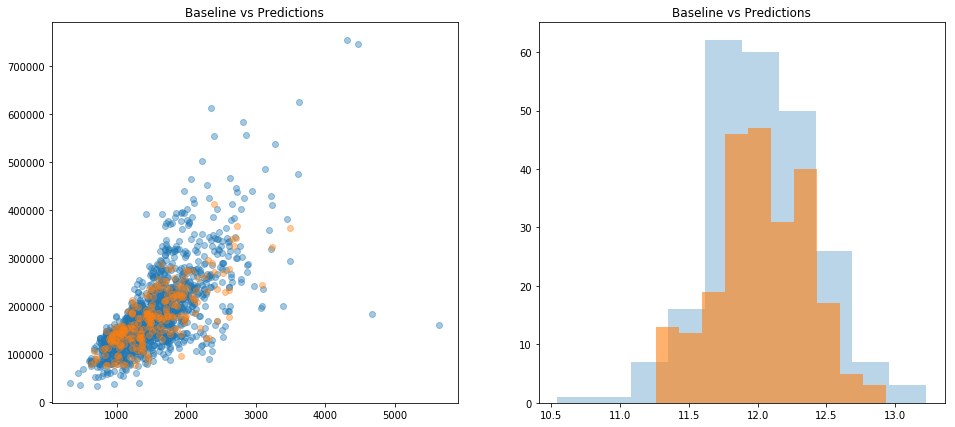

R2-score: 0.836660945557
RMSE (log): 0.15483981592962173


In [37]:
plot_benchmark(X_train_subset2, y_train_subset2, prediction_nn)

In [49]:
from sklearn.ensemble import BaggingRegressor

# Not we define a bagging ensemble for the blending
bagging_estimator = BaggingRegressor(Ridge(alpha=10, random_state=42, solver='cholesky', tol=0.001), n_estimators=500,
        max_samples=200, bootstrap=True)

In [50]:
# This blender now we train on the predictions of the first layer
X_blended = np.column_stack((prediction_nn, prediction_adaboost))

bagging_estimator.fit(X_blended, y_train_subset2)

BaggingRegressor(base_estimator=Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='cholesky', tol=0.001),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=200, n_estimators=500, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [52]:
# And now we use the stack to make a prediction on unseen data
test_prediction_ada = adaboost_estimator.predict(X_test)
test_prediction_nn = pipeline.predict(X_test)

X_test_blended = np.column_stack((test_prediction_nn, test_prediction_ada))
y_predicted = bagging_estimator.predict(X_test_blended)

292/292 [==============================] - 0s 163us/step


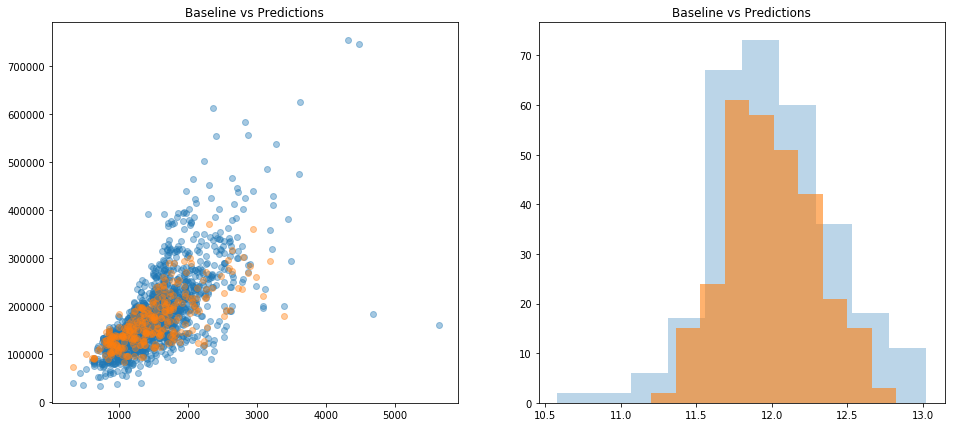

R2-score: 0.852247637916
RMSE (log): 0.15276053974514264


In [54]:
plot_benchmark(X_test, y_test, y_predicted)